# 0.0 Importando Bibliotecas

In [1]:
import pandas as pd
import inflection
import plotly.express as px
import plotly.graph_objects as go
import folium
from folium.plugins import MarkerCluster
from streamlit_folium import folium_static
import branca

# 0.1 Leitura do  dataset

In [2]:
df_raw = pd.read_csv( '../data/zomato.csv' )
df_raw.dtypes

Restaurant ID             int64
Restaurant Name          object
Country Code              int64
City                     object
Address                  object
Locality                 object
Locality Verbose         object
Longitude               float64
Latitude                float64
Cuisines                 object
Average Cost for two      int64
Currency                 object
Has Table booking         int64
Has Online delivery       int64
Is delivering now         int64
Switch to order menu      int64
Price range               int64
Aggregate rating        float64
Rating color             object
Rating text              object
Votes                     int64
dtype: object

# 0.2 Funções 

In [4]:
# renomear e formatar as colunas do dataframe
def rename_columns(dataframe):
    df = dataframe.copy()
    title = lambda x: inflection.titleize(x)
    snakecase = lambda x: inflection.underscore(x)
    spaces = lambda x: x.replace(" ", "")
    cols_old = list(df.columns)
    cols_old = list(map(title, cols_old))
    cols_old = list(map(spaces, cols_old))
    cols_new = list(map(snakecase, cols_old))
    df.columns = cols_new
    return df

# capturando nome do país
COUNTRIES = {
1: "India",
14: "Australia",
30: "Brazil",
37: "Canada",
94: "Indonesia",
148: "New Zeland",
162: "Philippines",
166: "Qatar",
184: "Singapure",
189: "South Africa",
191: "Sri Lanka",
208: "Turkey",
214: "United Arab Emirates",
215: "England",
216: "United States of America",
}

def country_name(country_id):
    return COUNTRIES[country_id]

# Criação do Tipo de Categoria de Comida
def create_price_tye(price_range):
    if price_range == 1:
        return "cheap"
    elif price_range == 2:
        return "normal"
    elif price_range == 3:
        return "expensive"
    else:
        return "gourmet"

COLORS = {
"3F7E00": "darkgreen",
"5BA829": "green",
"9ACD32": "lightgreen",
"CDD614": "orange",
"FFBA00": "red",
"CBCBC8": "darkred",
"FF7800": "darkred",
}

COUNTRY_LIST = ["India", "Australia", "Brazil", "Canada", "Indonesia", "New Zeland", "Philippines", "Qatar",
                "Singapure", "South Africa", "Sri Lanka", "Turkey", "United Arab Emirates", "England", "United States of America"]

def color_name(color_code):
    return COLORS[color_code]

def city_with_older_restaurant( df, city_list ):
    df = df[ df['city'].isin( city_list) ][ ['city', 'restaurant_id'] ].sort_values( 'restaurant_id').reset_index()
    return df.loc[0, 'city']

def get_restaurant_cuisines(df, cuisine, func):
    df_aux = df[ df['cuisines'] == cuisine] 
    
    if func == 'max':    
        df_aux = df_aux[ df_aux['aggregate_rating'] == df_aux['aggregate_rating'].max() ][['restaurant_id', 'restaurant_name', 'aggregate_rating']].sort_values('restaurant_id').reset_index()
    else:
        df_aux = df_aux[ df_aux['aggregate_rating'] == df_aux['aggregate_rating'].min() ][['restaurant_id', 'restaurant_name', 'aggregate_rating']].sort_values('restaurant_id').reset_index()

    return df_aux.loc[0, 'restaurant_name'], df_aux.loc[0, 'restaurant_id'], df_aux.loc[0, 'aggregate_rating'] 

def graph_country_detailed( df, metric):
    df_aux = df[['country_name', metric, 'restaurant_id']].groupby( ['country_name', metric] ).count().reset_index()
    
    country_dict  = {'country_name': COUNTRY_LIST, 
                 'yes': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 
                 'no' : [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
                }
    df_graph = pd.DataFrame( data=country_dict, index=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14] )

    for i in range( 0, df_aux.shape[0] ): 
        if df_aux.loc[i, metric] == 0:
            df_graph.loc[ df_graph['country_name'] == df_aux.loc[i, 'country_name'], 'no'] = df_aux.loc[i, 'restaurant_id']
        else:
            df_graph.loc[ df_graph['country_name'] == df_aux.loc[i, 'country_name'], 'yes'] = df_aux.loc[i, 'restaurant_id']

    fig = go.Figure(data=[
        go.Bar(name='Yes', x=df_graph['country_name'], y=df_graph['yes'], text=df_graph['yes'], textposition='auto'),
        go.Bar(name='No', x=df_graph['country_name'], y=df_graph['no'], text=df_graph['no'], textposition='auto')
    ])
    
    return fig

def get_better_restaurant_by_country( df ):
    list_country_name, list_restaurant_id, list_restaurant_name, list_aggregate_rating, list_votes = [], [], [], [], []
    df_aux = df[['country_name', 'restaurant_id', 'restaurant_name', 'aggregate_rating', 'votes']].reset_index()

    for country in COUNTRY_LIST:
        df2_aux = df_aux[ df_aux['country_name'] == country].sort_values( ['aggregate_rating', 'votes'], ascending=False ).reset_index()
        
        if df2_aux.shape[0] > 0:
            list_country_name.append( df2_aux.loc[0, 'country_name'] )
            list_restaurant_id.append( df2_aux.loc[0, 'restaurant_id'] )
            list_restaurant_name.append( df2_aux.loc[0, 'restaurant_name'] )
            list_aggregate_rating.append( df2_aux.loc[0, 'aggregate_rating'] )
            list_votes.append( df2_aux.loc[0, 'votes'] )

    dict = { 'country_name' : list_country_name,
             'restaurant_id' : list_restaurant_id,
             'restaurant_name' : list_restaurant_name,
             'aggregate_rating' : list_aggregate_rating,
             'votes' : list_votes }
    
    return pd.DataFrame( dict )


def get_map_restaurants_by_country( df ):
    # Desenhar o mapa
    map = folium.Map( zoom_start=11 )
    marker_cluster = MarkerCluster().add_to( map )    

    restaurant_name = df.loc[0, 'restaurant_name']
    price =    'Price: ' + str( round( df.loc[0, 'average_cost_for_two'], 2 ) ) + '(' + df.loc[0, 'currency'] + ') for two' 
    cuisines = 'Type: ' + df.loc[0, 'cuisines']
    rating =   'Aggregate_rating: ' + str( round( df.loc[0, 'aggregate_rating'], 2 ) ) + '/5.0 ' 

    html =        '<b> ' +  restaurant_name + '</b><br><br>'
    html = html + '<h> ' + price  + '</h><br>' 
    html = html + '<h> ' + cuisines + '</h><br>' 
    html = html + '<h> ' + rating  + '</h><br>'     

    for index, location_info in df.iterrows():
        iframe = branca.element.IFrame(html=html, width=300, height=120)
        popup = folium.Popup(iframe, max_width=300)

        folium.Marker( [location_info['latitude'],
                      location_info['longitude']],
                      popup=popup).add_to( marker_cluster )


    return map



# 1.0 Limpeza do DataSet

In [6]:
df1 = df_raw.copy()

In [7]:
# renomear e formatar as colunas do dataset
df1 = rename_columns( df1 )

# removendo linhas duplicadas
df1 = df1.drop_duplicates().reset_index()

# excluindo valores nulos das colunas
df1 = df1[ pd.isnull( df1['cuisines'] ) == False ].reset_index()

# restringindo somente um tipo de culinária por restaurante
df1['cuisines'] = df1['cuisines'].apply( lambda x: x.split(',')[0] )

# criando campo para capturar o nome do país
df1['country_name'] = df1['country_code'].apply( lambda x: country_name( x ) )

# 2.0 Visão - Geral

In [8]:
# copia do dataframe com dados limpos
df2 = df1.copy()

## 2.1 Perguntas

### 1. Quantos restaurantes únicos estão registrados ?

In [8]:
print( 'Total de restaurantes únicos: {} '.format( df2['restaurant_id'].nunique() ) )

Total de restaurantes únicos: 6929 


### 2. Quantos países únicos estão registrados?

In [10]:
print( 'Total de países únicos: {} '.format( df2['country_code'].nunique() ) )

Total de países únicos: 15 


### 3. Quantas cidades únicas estão registradas?

In [9]:
print( 'Total de cidades únicas: {} '.format( df2['city'].nunique() ) )

Total de cidades únicas: 125 


### 4. Qual o total de avaliações feitas?

In [11]:
print( 'Total de avaliações feitas: {} '.format( df2['votes'].sum() ) )

Total de avaliações feitas: 4194533 


### 5. Qual o total de tipos de culinária registrados?

In [12]:
print( 'Total de tipos de culinárias: {} '.format( df2['cuisines'].nunique() ) )

Total de tipos de culinárias: 165 


## 2.2 Mapa

In [113]:
map = get_map_restaurants_by_country( df2 )
map

# 3.0 Visão - Países

In [14]:
df3 = df1.copy()

## 3.1 Perguntas

### 1. Qual o nome do país que possui mais cidades registradas?

In [15]:
df_aux = df3[['country_name', 'city']].groupby(['country_name', 'city']).count().reset_index()
df_aux['contador'] = 1
df_aux = df_aux[['country_name', 'contador']].groupby('country_name').sum().sort_values( 'contador', ascending=False ).reset_index()
print( 'O país com mais cidades registradas é {0} com {1} cidades'.format( df_aux.loc[0, 'country_name'], df_aux.loc[0, 'contador'] ) )


O país com mais cidades registradas é India com 49 cidades


### 2. Qual o nome do país que possui mais restaurantes registrados?

In [16]:
df_aux = df3[['country_name', 'restaurant_id']].groupby('country_name').count().sort_values( 'restaurant_id', ascending=False ).reset_index()
print( 'O país com mais restaurantse registradas é {0} com {1} restaurantes'.format( df_aux.loc[0, 'country_name'], df_aux.loc[0, 'restaurant_id'] ) )


O país com mais restaurantse registradas é India com 3111 restaurantes


### 3. Qual o nome do país que possui mais restaurantes com o nível de preço igual a 4 registrados?

In [17]:
df_aux = df3[ df3['price_range'] == 4]
df_aux = df_aux[['country_name', 'restaurant_id']].groupby('country_name').count().sort_values( 'restaurant_id', ascending=False ).reset_index()
print( 'O país com mais restaurantes nível 4 é {0} com {1} restaurantes'.format( df_aux.loc[0, 'country_name'], df_aux.loc[0, 'restaurant_id'] ) )


O país com mais restaurantes nível 4 é United States of America com 415 restaurantes


### 4. Qual o nome do país que possui a maior quantidade de tipos de culinária distintos?

In [18]:
df_aux = df3[['country_name', 'cuisines']].groupby( ['country_name', 'cuisines'] ).count().reset_index()
df_aux = df_aux[['country_name', 'cuisines']].groupby( 'country_name' ).count().sort_values( 'cuisines', ascending=False ).reset_index()                                
print( 'O país que possui a maior quantidade de tipos de culinárias distintos é {0} com {1} culinárias '.format( df_aux.loc[0, 'country_name'], df_aux.loc[0, 'cuisines'] ) )


O país que possui a maior quantidade de tipos de culinárias distintos é India com 77 culinárias 


### 5. Qual o nome do país que possui a maior quantidade de avaliações feitas?

In [19]:
df_aux = df3[['country_name', 'votes']].groupby( 'country_name' ).sum().sort_values( 'votes', ascending=False ).reset_index()
print( 'O país que possui a maior quantidade de avaliações feitas é {0} com {1} avaliações '.format( df_aux.loc[0, 'country_name'], df_aux.loc[0, 'votes'] ) )


O país que possui a maior quantidade de avaliações feitas é India com 2800164 avaliações 


### 6. Qual o nome do país que possui a maior quantidade de restaurantes que fazem entrega?

In [20]:
df_aux = df3[ df3['is_delivering_now'] == 1 ]
df_aux = df_aux[['country_name', 'restaurant_id']].groupby( 'country_name' ).count().sort_values( 'restaurant_id', ascending=False ).reset_index()
print( 'O país que possui a maior quantidade de restaurantes que fazem entrega é {0} com {1} restaurantes '.format( df_aux.loc[0, 'country_name'], df_aux.loc[0, 'restaurant_id'] ) )


O país que possui a maior quantidade de restaurantes que fazem entrega é India com 1150 restaurantes 


### 7. Qual o nome do país que possui a maior quantidade de restaurantes que aceitam reservas?

In [21]:
df_aux = df3[ df3['has_table_booking'] == 1 ]
df_aux = df_aux[['country_name', 'restaurant_id']].groupby( 'country_name' ).count().sort_values( 'restaurant_id', ascending=False ).reset_index()
print( 'O país que possui a maior quantidade de restaurantes que aceitam reservas é {0} com {1} restaurantes '.format( df_aux.loc[0, 'country_name'], df_aux.loc[0, 'restaurant_id'] ) )


O país que possui a maior quantidade de restaurantes que aceitam reservas é India com 256 restaurantes 


### 8. Qual o nome do país que possui, na média, a maior quantidade de avaliações registrada?

In [22]:
df_aux = df3[ ['country_name', 'votes'] ].groupby( 'country_name' ).mean().sort_values( 'votes', ascending=False ).reset_index()
print( 'O país que possui, na média, a maior quantidade de avaliações registradas é {0} com {1} avaliaçoes '.format( df_aux.loc[0, 'country_name'], df_aux.loc[0, 'votes'] ) )


O país que possui, na média, a maior quantidade de avaliações registradas é Indonesia com 1112.825 avaliaçoes 


### 9. Qual o nome do país que possui, na média, a maior nota média registrada?

In [23]:
df_aux = df3[ ['country_name', 'aggregate_rating'] ].groupby('country_name').mean().sort_values( 'aggregate_rating', ascending=False ).reset_index()
print( 'O país que possui, na média, a maior nota média registrada é {0} com nota média de {1} '.format( df_aux.loc[0, 'country_name'], round( df_aux.loc[0, 'aggregate_rating'], 2 ) ) )


O país que possui, na média, a maior nota média registrada é Indonesia com nota média de 4.6 


### 10. Qual o nome do país que possui, na média, a menor nota média registrada?

In [24]:
df_aux = df3[ ['country_name', 'aggregate_rating'] ].groupby('country_name').mean().sort_values( 'aggregate_rating' ).reset_index()
print( 'O país que possui, na média, a maior nota média registrada é {0} com nota média de {1} '.format( df_aux.loc[0, 'country_name'], round( df_aux.loc[0, 'aggregate_rating'], 2 ) ) )


O país que possui, na média, a maior nota média registrada é Brazil com nota média de 3.32 


### 11. Qual a média de preço de um prato para dois por país?

In [25]:
df_aux = df3[ ['country_name', 'average_cost_for_two'] ].groupby( 'country_name' ).mean().sort_values( 'average_cost_for_two').reset_index()
df_aux


country_name  average_cost_for_two
0                     Canada             41.861111
1                    England             43.510000
2   United States of America             55.029840
3                 New Zeland             62.154812
4                     Turkey            128.584906
5                     Brazil            138.812500
6                  Singapure            141.437500
7       United Arab Emirates            153.716667
8                      Qatar            174.000000
9               South Africa            339.228324
10                     India            704.400514
11               Philippines           1227.825000
12                 Sri Lanka           2579.375000
13                 Australia         138959.783333
14                 Indonesia         303000.000000

## 3.2 Gráficos

### 3.2.1 Quantidade de Restaurantes por País

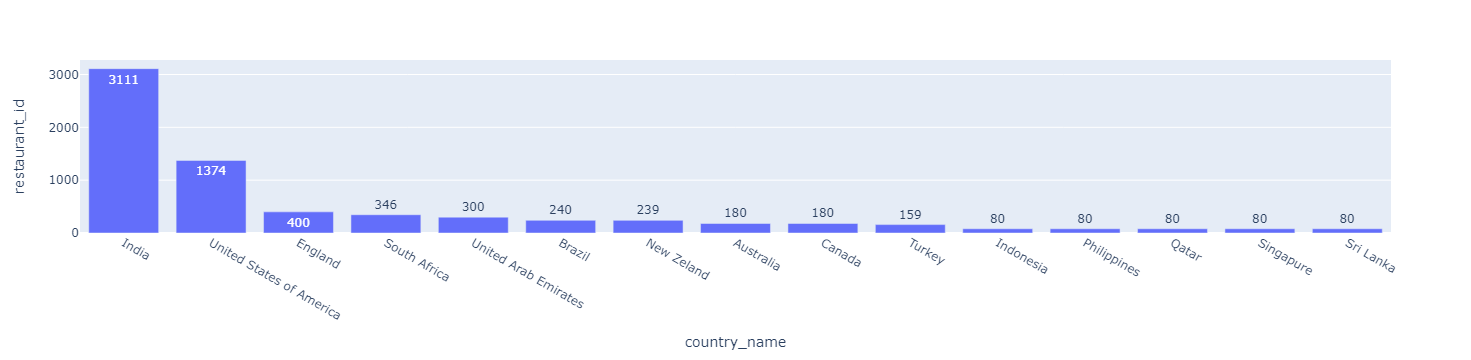

In [90]:
df_aux = df3[['country_name', 'restaurant_id']].groupby('country_name').count().sort_values( 'restaurant_id', ascending=False ).reset_index()
#df_aux
px.bar( df_aux, x='country_name', y='restaurant_id', text_auto=True, height=600)

### 3.2.2 Quantidade de Restaurantes por País e Se o restaurante permite reserva

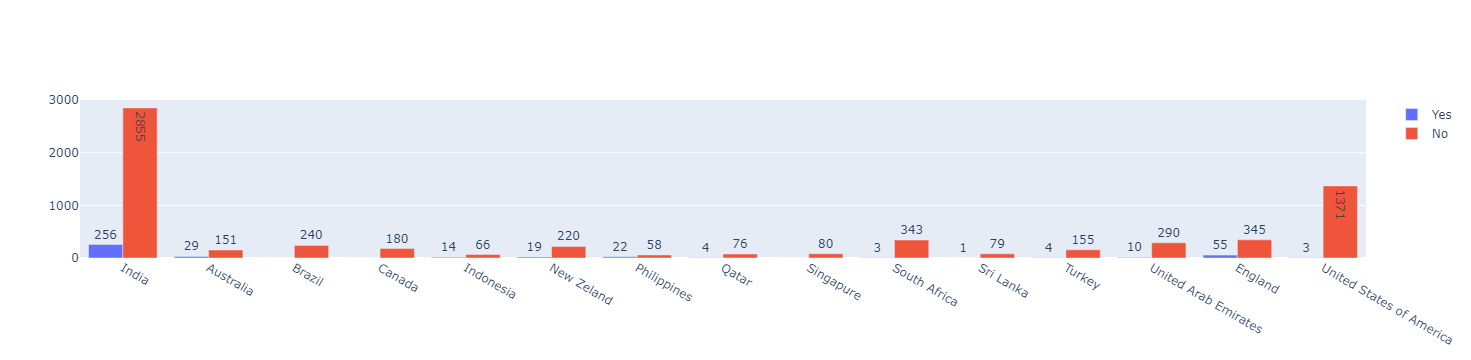

In [91]:
# Quantidade de Restaurantes por País e por Reserva
fig = graph_country_detailed( df3, 'has_table_booking')

# Change the bar mode e show graph
fig.update_layout(barmode='group', height=600)
fig.show()                          


### 3.2.3 Quantidade de Restaurantes por País e Se o Restaurante Faz Entrega

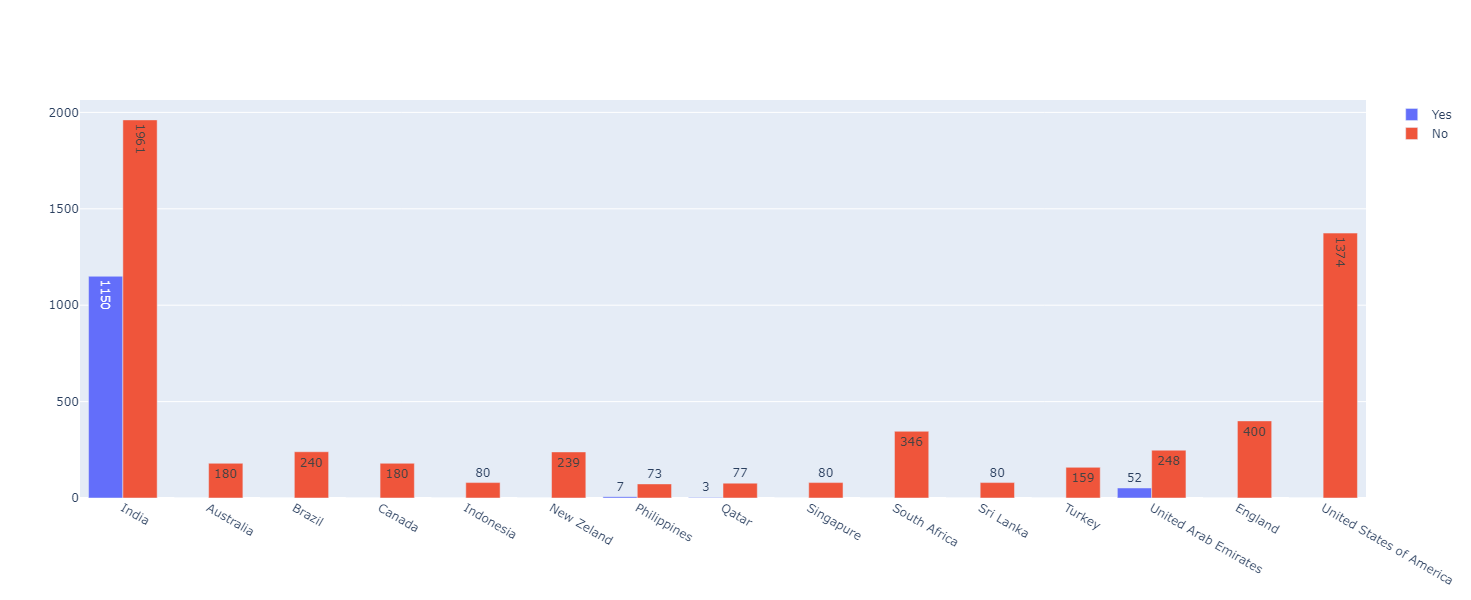

In [92]:
# Quantidade de Restaurantes por País e por Entrega
fig = graph_country_detailed( df3, 'is_delivering_now')

# Change the bar mode e show graph
fig.update_layout(barmode='group', height=600)
fig.show()    

### 3.2.4 Quantidade de Restaurantes por País e Se o Restaurante Aceita Pedido On-Line

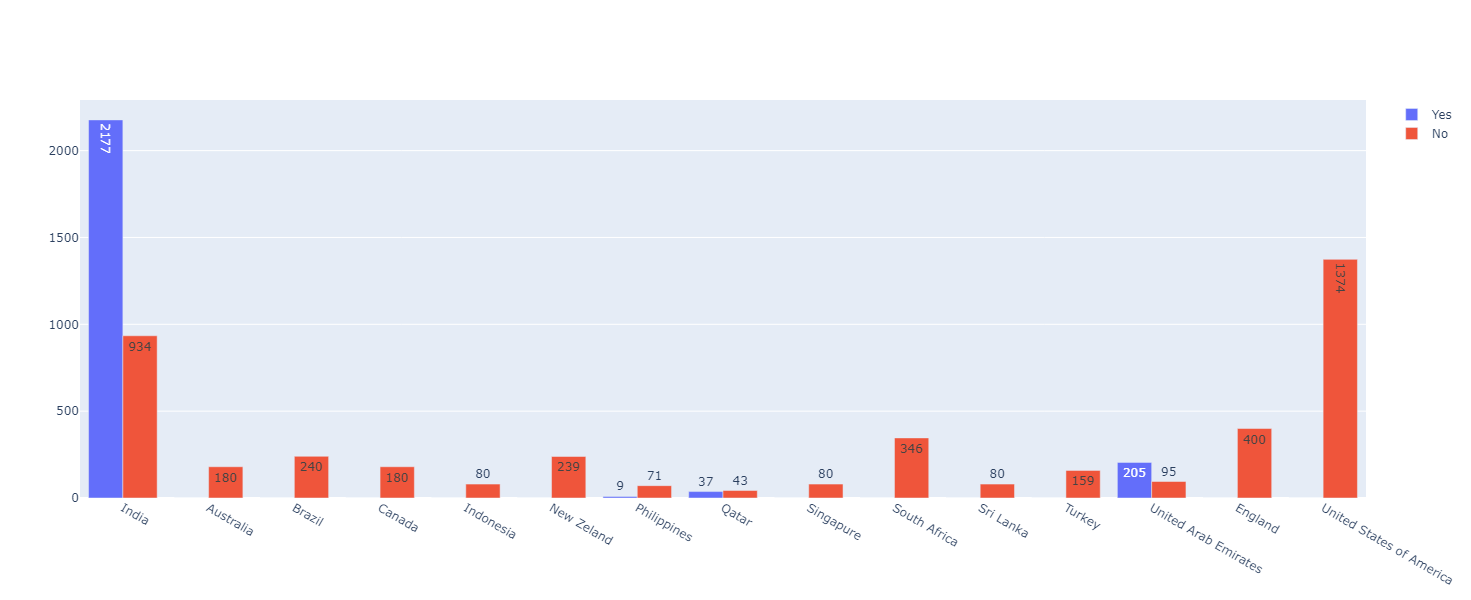

In [77]:
# Quantidade de Restaurantes por País e Aceita Pedido On-Line
fig = graph_country_detailed( df3, 'has_online_delivery')

# Change the bar mode e show graph
fig.update_layout(barmode='group', height=600)
fig.show()    

### 3.2.5 Média do Prato para 2 Pessoas por País

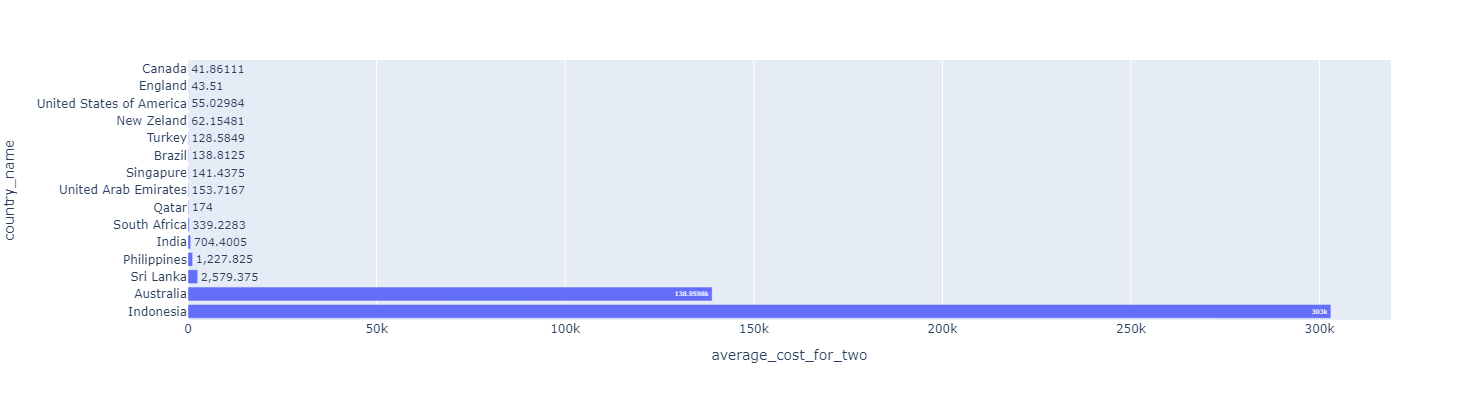

In [100]:
# Média de Prato para 2 por País
df_aux = df3[['country_name', 'average_cost_for_two']].groupby('country_name').mean().sort_values( 'average_cost_for_two', ascending=False ).reset_index()
#df_aux
px.bar( df_aux, y='country_name', x='average_cost_for_two', text_auto=True, height=400, width=800)

### 3.2.6 Média das Notas dos Restaurantes por País

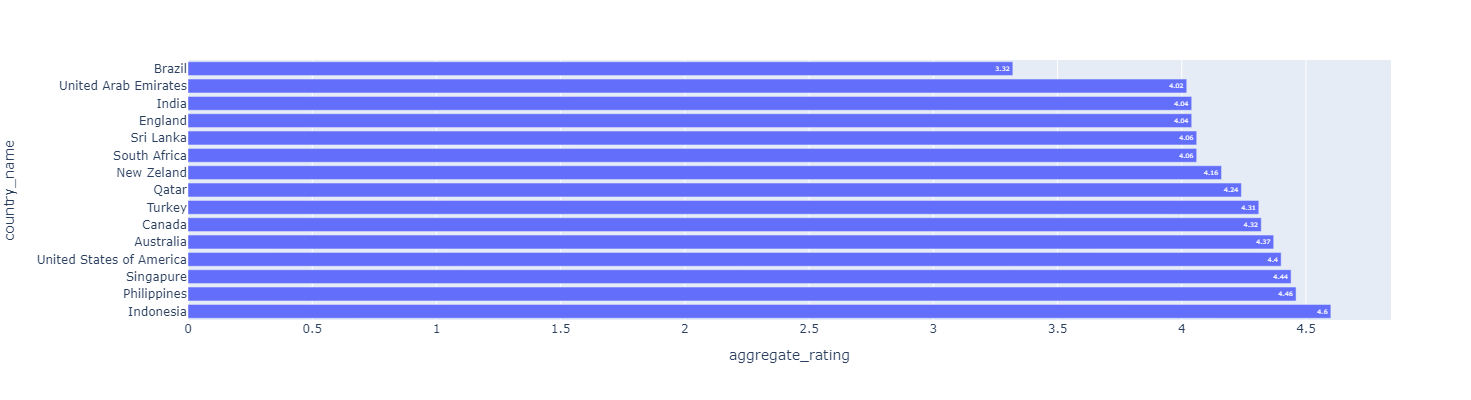

In [101]:
# Média de Rating  por País
df_aux = df3[['country_name', 'aggregate_rating']].groupby('country_name').mean().sort_values( 'aggregate_rating', ascending=False ).reset_index()
df_aux['aggregate_rating'] = round( df_aux['aggregate_rating'] , 2)
px.bar( df_aux, y='country_name', x='aggregate_rating', text_auto=True, height=400, width=800)

### 3.2.7 Tabela de Melhor Restaurante por País

In [148]:
get_better_restaurant_by_country( df3 )

country_name  restaurant_id              restaurant_name  \
0                      India          58882  Byg Brewski Brewing Company   
1                  Australia       16598431               Tuck Shop Cafe   
2                     Brazil        7302898                    Aprazível   
3                     Canada       16631515            OEB Breakfast Co.   
4                  Indonesia       18567253                   Sushi Hiro   
5                 New Zeland        7001086                        Milse   
6                Philippines        6316125            Mendokoro Ramenba   
7                      Qatar       18187643             Max's Restaurant   
8                  Singapure       18485435            The Curry Culture   
9               South Africa       18204217           Gemelli Cucina Bar   
10                 Sri Lanka        5801077     Noodles - Cinnamon Grand   
11                    Turkey        5907325             Bayramoğlu Döner   
12      United Arab Emirates         207770          Mint Leaf of London   
13                   England        6103211                      Dishoom   
14  United States of America       17242247                Café Du Monde   

    aggregate_rating  votes  
0                4.9  17394  
1                4.9   2822  
2                4.9     63  
3                4.9   1477  
4                4.9   4416  
5                4.9    997  
6                4.9   1832  
7                4.9    450  
8                4.9     80  
9                4.9    993  
10               4.8    206  
11               4.9   1949  
12               4.9   2092  
13               4.9   1023  
14               4.9   4036

# 4.0 Visão - Cidades 

## 4.1 Perguntas

In [26]:
df4 = df1.copy()

### 1. Qual o nome da cidade que possui mais restaurantes registrados?

In [29]:
df_aux = df4[ ['city', 'restaurant_id'] ].groupby('city').count().sort_values( 'restaurant_id', ascending=False).reset_index()
df_aux = df_aux[ df_aux['restaurant_id'] == df_aux['restaurant_id'].max() ]
city_list = df_aux.loc[:, 'city'].to_list()
df_aux = df_aux[ df_aux['city'] == city_with_older_restaurant( df4, city_list ) ].reset_index()
#df_aux

print( 'A cidade que possui mais restaurantes registrados é {0} com {1} restaurantes'.format( df_aux.loc[0, 'city'], df_aux.loc[0, 'restaurant_id'] ) )


A cidade que possui mais restaurantes registrados é Pune com 80 restaurantes


### 2. Qual o nome da cidade que possui mais restaurantes com nota média acima de 4?

In [28]:
df_aux = df4[ df4['aggregate_rating'] > 4]
df_aux = df_aux[ ['city', 'restaurant_id'] ].groupby('city').count().sort_values( 'restaurant_id', ascending=False).reset_index()
#df_aux

print( 'A cidade que possui mais restaurantes com nota média acima de 4 é {0} com {1} restaurantes'.format( df_aux.loc[0, 'city'], df_aux.loc[0, 'restaurant_id'] ) )


A cidade que possui mais restaurantes com nota média acima de 4 é Bangalore com 79 restaurantes


### 3. Qual o nome da cidade que possui mais restaurantes com nota média abaixo de 2.5?

In [30]:
df_aux = df4[ df4['aggregate_rating'] < 2.5]
df_aux = df_aux[ ['city', 'restaurant_id'] ].groupby('city').count().sort_values( 'restaurant_id', ascending=False).reset_index()
#df_aux

print( 'A cidade que possui mais restaurantes com nota média abaixo de 2.5 é {0} com {1} restaurantes'.format( df_aux.loc[0, 'city'], df_aux.loc[0, 'restaurant_id'] ) )


A cidade que possui mais restaurantes com nota média abaixo de 2.5 é Gangtok com 33 restaurantes


### 4. Qual o nome da cidade que possui o maior valor médio de um prato para dois?

In [31]:
df_aux = df4[ ['city', 'average_cost_for_two'] ].groupby('city').mean().sort_values( 'average_cost_for_two', ascending=False).reset_index()
#df_aux

print( 'A cidade que possui o maior valor médio de um prato para dois é {0} com {1} de valor médio'.format( df_aux.loc[0, 'city'], round( df_aux.loc[0, 'average_cost_for_two'], 2 ) ) )

A cidade que possui o maior valor médio de um prato para dois é Adelaide com 416734.13 de valor médio


### 5. Qual o nome da cidade que possui a maior quantidade de tipos de culinária distintas?

In [32]:
df_aux = df4[ ['city', 'cuisines']].groupby( ['city', 'cuisines'] ).count().reset_index()
df_aux = df_aux[['city', 'cuisines']].groupby( 'city' ).count().sort_values( 'cuisines', ascending=False).reset_index()
#df_aux

print( 'A cidade que possui a maior quantidade de tipos de culinária distintas é {0} com {1} culinárias'.format( df_aux.loc[0, 'city'], df_aux.loc[0, 'cuisines'] ) )

A cidade que possui a maior quantidade de tipos de culinária distintas é Birmingham com 32 culinárias


### 6. Qual o nome da cidade que possui a maior quantidade de restaurantes que fazem reservas?

In [33]:
df_aux = df4[ df4['has_table_booking'] == 1] 
df_aux = df_aux[['city', 'restaurant_id']].groupby('city').count().sort_values( 'restaurant_id', ascending=False).reset_index()
#df_aux

print( 'A cidade que possui a maior quantidade de restaurantes que fazem reservas é {0} com {1} restaurantes'.format( df_aux.loc[0, 'city'], df_aux.loc[0, 'restaurant_id'] ) )


A cidade que possui a maior quantidade de restaurantes que fazem reservas é Bangalore com 42 restaurantes


### 7. Qual o nome da cidade que possui a maior quantidade de restaurantes que fazem entregas?

In [34]:
df_aux = df4[ df4['is_delivering_now'] == 1]
df_aux = df_aux[['city', 'restaurant_id']].groupby('city').count().sort_values( 'restaurant_id', ascending=False).reset_index()
df_aux = df_aux[ df_aux['restaurant_id'] == df_aux['restaurant_id'].max() ]

# chamando a função que verifica qual das cidades que possui o restaurant_id mais antigo
city_list = df_aux.loc[:, 'city'].to_list()
df_aux = df_aux[ df_aux['city'] == city_with_older_restaurant( df4, city_list ) ].reset_index()
#df_aux

print( 'A cidade que possui a maior quantidade de restaurantes que fazem entregas é {0} com {1} restaurantes'.format( df_aux.loc[0, 'city'], df_aux.loc[0, 'restaurant_id'] ) )


A cidade que possui a maior quantidade de restaurantes que fazem entregas é Amritsar com 48 restaurantes


### 8. Qual o nome da cidade que possui a maior quantidade de restaurantes que aceitam pedidos online?

In [35]:
df_aux = df4[ df4['has_online_delivery'] == 1]
df_aux = df_aux[['city', 'restaurant_id']].groupby('city').count().sort_values( 'restaurant_id', ascending=False).reset_index()
#df_aux

print( 'A cidade que possui a maior quantidade de restaurantes que aceitam pedidos online é {0} com {1} restaurantes'.format( df_aux.loc[0, 'city'], df_aux.loc[0, 'restaurant_id'] ) )


A cidade que possui a maior quantidade de restaurantes que aceitam pedidos online é Bhopal com 75 restaurantes


## 4.2 Gráficos

### 4.2.1 Top 10 Cidades com mais restaurantes

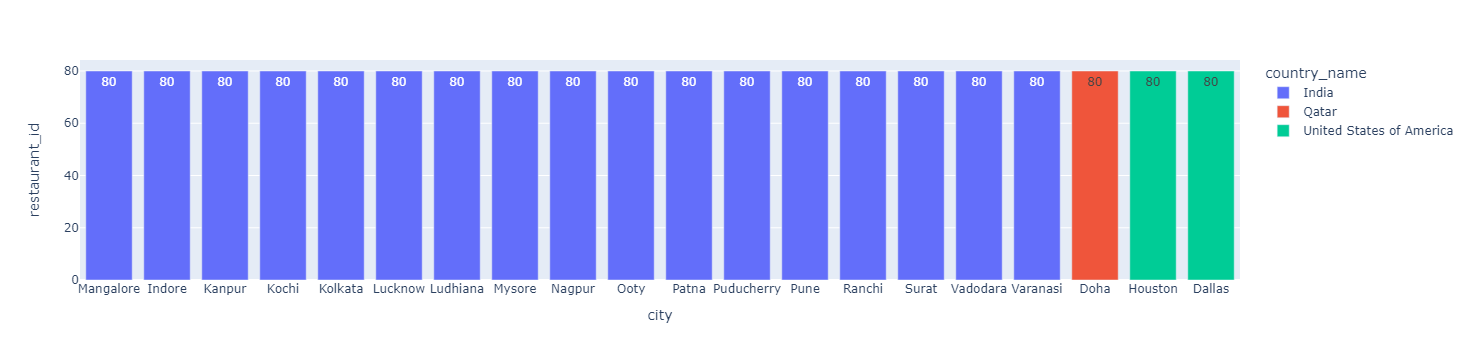

In [181]:
df_aux = df4[ ['country_name', 'city', 'restaurant_id'] ].groupby( ['country_name', 'city'] ).count().sort_values( 'restaurant_id', ascending=False).reset_index()
df_aux = df_aux.loc[0:19, :]
df_aux

px.bar( df_aux, x='city', y='restaurant_id', color='country_name', text_auto=True, height=500)

### 4.2.2 Top 10 Cidades com mais tipos de culinárias

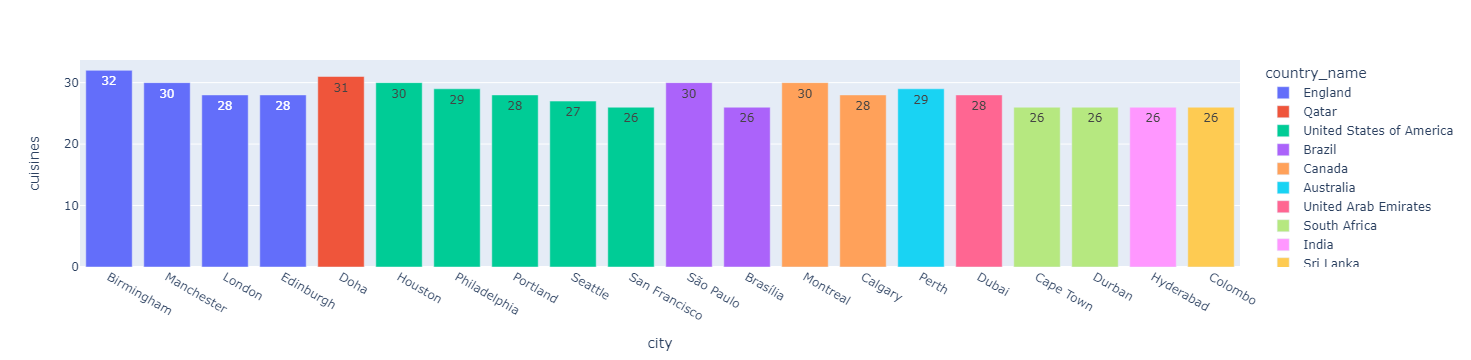

In [186]:
df_aux = df4[ ['country_name', 'city', 'cuisines'] ].groupby( ['country_name', 'city', 'cuisines'] ).count().sort_values( ['country_name', 'city', 'cuisines'] ).reset_index()
df_aux = df_aux[['country_name', 'city', 'cuisines'] ].groupby( ['country_name', 'city'] ).count().sort_values( 'cuisines', ascending=False ).reset_index()
df_aux = df_aux.loc[0:19, :]
df_aux

px.bar( df_aux, x='city', y='cuisines', color='country_name', text_auto=True, height=500)

# 5.0 Visão - Restaurantes

In [36]:
# copia do dataframe com dados limpos
df5 = df1.copy()

## 5.1 Perguntas

### 1. Qual o restaurante que possui a maior quantidade de avaliações?

In [253]:
df_aux =df5[ df5['votes'] == df5['votes'].max() ][ ['restaurant_id', 'restaurant_name', 'votes'] ].sort_values( 'restaurant_id' ).reset_index()
#df_aux

print('O restaurante que possui a maior quantidade de avaliações é {0} (id={1}) com {2} avaliações'.format( df_aux.loc[0, 'restaurant_name'], df_aux.loc[0, 'restaurant_id'], df_aux.loc[0, 'votes'] ) )

O restaurante que possui a maior quantidade de avaliações é Bawarchi (id=90896) com 41333 avaliações


### 2. Qual o nome do restaurante com a maior nota média?

In [37]:
df_aux =df5[ df5['aggregate_rating'] == df5['aggregate_rating'].max() ][ ['restaurant_id', 'restaurant_name', 'aggregate_rating'] ].sort_values( 'restaurant_id' ).reset_index()
#df_aux

print('O restaurante com a maior nota média é {0} (id={1}) com {2} de nota média'.format( df_aux.loc[0, 'restaurant_name'], df_aux.loc[0, 'restaurant_id'], df_aux.loc[0, 'aggregate_rating'] ) )


O restaurante com a maior nota média é Indian Grill Room (id=7528) com 4.9 de nota média


### 3. Qual o nome do restaurante que possui o maior valor de uma prato para duas pessoas?

In [38]:
df_aux =df5[ df5['average_cost_for_two'] == df5['average_cost_for_two'].max() ][ ['restaurant_id', 'restaurant_name', 'average_cost_for_two'] ].sort_values( 'restaurant_id' ).reset_index()
#df_aux

print('O restaurante que possui o maior valor de uma prato para duas pessoas é {0} (id={1}) com {2} de custo'.format( df_aux.loc[0, 'restaurant_name'], df_aux.loc[0, 'restaurant_id'], df_aux.loc[0, 'average_cost_for_two'] ) )


O restaurante que possui o maior valor de uma prato para duas pessoas é d'Arry's Verandah Restaurant (id=16608070) com 25000017 de custo


### 4. Qual o nome do restaurante de tipo de culinária brasileira que possui a menor média de avaliação?

In [39]:
df_aux = df5[ df5['cuisines'] == 'Brazilian'][ ['restaurant_id', 'restaurant_name', 'aggregate_rating'] ].reset_index()
df_aux = df_aux[ df_aux['aggregate_rating'] == df_aux['aggregate_rating'].min() ].sort_values( 'restaurant_id' ).reset_index()
#df_aux

print('O restaurante de tipo de culinária brasileira que possui a menor média de avaliação é {0} (id={1}) com {2} de média'.format( df_aux.loc[0, 'restaurant_name'], df_aux.loc[0, 'restaurant_id'], df_aux.loc[0, 'aggregate_rating'] ) )


O restaurante de tipo de culinária brasileira que possui a menor média de avaliação é Loca Como tu Madre (id=6600100) com 0.0 de média


### 5. Qual o nome do restaurante de tipo de culinária brasileira, e que é do Brasil, que possui a maior média de avaliação?

In [40]:
df_aux = df5[ ( df5['cuisines'] == 'Brazilian' ) & ( df5['country_name'] == 'Brazil' ) ][ ['restaurant_id', 'restaurant_name', 'aggregate_rating'] ].reset_index()
df_aux = df_aux[ df_aux['aggregate_rating'] == df_aux['aggregate_rating'].max() ].sort_values( 'restaurant_id' ).reset_index()
#df_aux

print('O restaurante de tipo de culinária brasileira, e que é do Brasil, que possui a maior média de avaliação é {0} (id={1}) com {2} de média'.format( df_aux.loc[0, 'restaurant_name'], df_aux.loc[0, 'restaurant_id'], df_aux.loc[0, 'aggregate_rating'] ) )


O restaurante de tipo de culinária brasileira, e que é do Brasil, que possui a maior média de avaliação é Braseiro da Gávea (id=7300955) com 4.9 de média


### 6. Os restaurantes que aceitam pedido online são também, na média, os restaurantes que mais possuem avaliações registradas?

In [41]:
mean_online = round( df5[ df5['has_online_delivery'] == 1]['votes'].mean(), 2)
mean_no_online = round( df5[ df5['has_online_delivery'] == 0]['votes'].mean(), 2 )

print('SIM. A média de avaliações dos restaurantes que aceitam pedidos on-line é de {0}, enquando que a média dos que não aceitam é de {1}'.format( mean_online, mean_no_online ) )


SIM. A média de avaliações dos restaurantes que aceitam pedidos on-line é de 838.82, enquando que a média dos que não aceitam é de 479.42


### 7. Os restaurantes que fazem reservas são também, na média, os restaurantes que possuem o maior valor médio de um prato para duas pessoas?

In [42]:
mean_booking = round( df5[ df5['has_table_booking'] == 1]['average_cost_for_two'].mean(), 2)
mean_no_booking = round( df5[ df5['has_table_booking'] == 0]['average_cost_for_two'].mean(), 2 )

print('SIM. A média de prato para duas pessoas dos restaurantes que aceitam fazem reserva é de {0}, enquando que a média dos que não fazem é de {1}'.format( mean_booking, mean_no_booking ) )


SIM. A média de prato para duas pessoas dos restaurantes que aceitam fazem reserva é de 69998.42, enquando que a média dos que não fazem é de 3488.6


### 8. Os restaurantes do tipo de culinária japonesa dos Estados Unidos da América que possuem um valor médio de prato para duas pessoas maior que as churrascarias americanas (BBQ)?

In [43]:
df_aux = df5[ df5['country_name'] == 'United States of America']

mean_japanese_usa = round( df_aux[ df_aux['cuisines'] == 'Japanese']['average_cost_for_two'].mean(), 2)
mean_bbq_usa = round( df_aux[ df_aux['cuisines'] == 'BBQ']['average_cost_for_two'].mean(), 2)

print('SIM. A média de prato para duas pessoas dos restaurantes americanos de culinária japonesa é de {0}, enquando que nos restaurantes americanos de culinária BBQ é de {1}'.format( mean_japanese_usa, mean_bbq_usa ) )


SIM. A média de prato para duas pessoas dos restaurantes americanos de culinária japonesa é de 56.41, enquando que nos restaurantes americanos de culinária BBQ é de 39.64


# 6.0 Visão - Tipos de Culinárias

In [44]:
# cópia do dataframe com dados limpos
df6 = df1.copy()

## 6.1 Perguntas

### 1. Dos restaurantes que possuem o tipo de culinária italiana, qual o nome do restaurante com a maior média de avaliação?

In [45]:
restaurant_name, restaurant_id, aggregate_rating = get_restaurant_cuisines(df6, 'Italian', 'max')
print( 'O restaurante de culinária italiana de maior média de avaliação é o {0} (id={1}) com média de {2}'.format( restaurant_name, restaurant_id, aggregate_rating ) )


O restaurante de culinária italiana de maior média de avaliação é o Darshan (id=10021) com média de 4.9


### 2. Dos restaurantes que possuem o tipo de culinária italiana, qual o nome do restaurante com a menor média de avaliação ?

In [46]:
restaurant_name, restaurant_id, aggregate_rating = get_restaurant_cuisines(df6, 'Italian', 'min')
print( 'O restaurante de culinária italiana de menor média de avaliação é o {0} (id={1}) com média de {2}'.format( restaurant_name, restaurant_id, aggregate_rating ) )


O restaurante de culinária italiana de menor média de avaliação é o Avenida Paulista (id=6600542) com média de 0.0


### 3. Dos restaurantes que possuem o tipo de culinária americana, qual o nome do restaurante com a maior média de avaliação?

In [47]:
restaurant_name, restaurant_id, aggregate_rating = get_restaurant_cuisines(df6, 'American', 'max')
print( 'O restaurante de culinária americana de maior média de avaliação é o {0} (id={1}) com média de {2}'.format( restaurant_name, restaurant_id, aggregate_rating ) )


O restaurante de culinária americana de maior média de avaliação é o Burger & Lobster (id=6102616) com média de 4.9


### 4. Dos restaurantes que possuem o tipo de culinária americana, qual o nome do restaurante com a menor média de avaliação?

In [48]:
restaurant_name, restaurant_id, aggregate_rating = get_restaurant_cuisines(df6, 'American', 'min')
print( 'O restaurante de culinária americana de menor média de avaliação é o {0} (id={1}) com média de {2}'.format( restaurant_name, restaurant_id, aggregate_rating ) )


O restaurante de culinária americana de menor média de avaliação é o Alston Bar & Beef (id=18756337) com média de 0.0


### 5. Dos restaurantes que possuem o tipo de culinária árabe, qual o nome do restaurante com a maior média de avaliação?

In [49]:
restaurant_name, restaurant_id, aggregate_rating = get_restaurant_cuisines(df6, 'Arabian', 'max')
print( 'O restaurante de culinária árabe de maior média de avaliação é o {0} (id={1}) com média de {2}'.format( restaurant_name, restaurant_id, aggregate_rating ) )


O restaurante de culinária árabe de maior média de avaliação é o Mandi@36 (id=18535007) com média de 4.7


### 6. Dos restaurantes que possuem o tipo de culinária árabe, qual o nome do restaurante com a menor média de avaliação?

In [50]:
restaurant_name, restaurant_id, aggregate_rating = get_restaurant_cuisines(df6, 'Arabian', 'min')
print( 'O restaurante de culinária árabe de menor média de avaliação é o {0} (id={1}) com média de {2}'.format( restaurant_name, restaurant_id, aggregate_rating ) )


O restaurante de culinária árabe de menor média de avaliação é o Raful (id=6706513) com média de 0.0


### 7. Dos restaurantes que possuem o tipo de culinária japonesa, qual o nome do restaurante com a maior média de avaliação?

In [51]:
restaurant_name, restaurant_id, aggregate_rating = get_restaurant_cuisines(df6, 'Japanese', 'max')
print( 'O restaurante de culinária japonesa de maior média de avaliação é o {0} (id={1}) com média de {2}'.format( restaurant_name, restaurant_id, aggregate_rating ) )


O restaurante de culinária japonesa de maior média de avaliação é o Sushi Samba (id=6107336) com média de 4.9


### 8. Dos restaurantes que possuem o tipo de culinária japonesa, qual o nome do restaurante com a menor média de avaliação?

In [52]:
restaurant_name, restaurant_id, aggregate_rating = get_restaurant_cuisines(df6, 'Japanese', 'min')
print( 'O restaurante de culinária japonesa de menor média de avaliação é o {0} (id={1}) com média de {2}'.format( restaurant_name, restaurant_id, aggregate_rating ) )


O restaurante de culinária japonesa de menor média de avaliação é o Banzai Sushi (id=6600203) com média de 0.0


### 9. Dos restaurantes que possuem o tipo de culinária caseira, qual o nome do restaurante com a maior média de avaliação?

In [53]:
restaurant_name, restaurant_id, aggregate_rating = get_restaurant_cuisines(df6, 'Home-made', 'max')
print( 'O restaurante de culinária caseira de maior média de avaliação é o {0} (id={1}) com média de {2}'.format( restaurant_name, restaurant_id, aggregate_rating ) )


O restaurante de culinária caseira de maior média de avaliação é o Kanaat Lokantası (id=5914190) com média de 4.0


### 10. Dos restaurantes que possuem o tipo de culinária caseira, qual o nome do restaurante com a menor média de avaliação?

In [54]:
restaurant_name, restaurant_id, aggregate_rating = get_restaurant_cuisines(df6, 'Home-made', 'min')
print( 'O restaurante de culinária caseira de menor média de avaliação é o {0} (id={1}) com média de {2}'.format( restaurant_name, restaurant_id, aggregate_rating ) )


O restaurante de culinária caseira de menor média de avaliação é o GurMekan Restaurant (id=6007184) com média de 3.7


## 11. Qual o tipo de culinária que possui o maior valor médio de um prato para duas pessoas?

In [55]:
df_aux = df6[['cuisines', 'average_cost_for_two']].groupby( 'cuisines' ).mean().sort_values( 'average_cost_for_two', ascending=False).reset_index()
df_aux['average_cost_for_two'] = round( df_aux['average_cost_for_two'], 2)
#df_aux

print( 'O tipo de culinária que possui o maior valor médio de um prato para duas pessoas é o {0} com média de {1}'.format( df_aux.loc[0, 'cuisines'], df_aux.loc[0, 'average_cost_for_two'] ) )


O tipo de culinária que possui o maior valor médio de um prato para duas pessoas é o Modern Australian com média de 1470693.06


### 12. Qual o tipo de culinária que possui a maior nota média?

In [56]:
df_aux = df6[['cuisines', 'aggregate_rating']].groupby( 'cuisines' ).mean().sort_values( 'aggregate_rating', ascending=False).reset_index()
df_aux['aggregate_rating'] = round( df_aux['aggregate_rating'], 2)
#df_aux

print( 'O tipo de culinária que possui a maior nota média é o {0} com média de {1}'.format( df_aux.loc[0, 'cuisines'], df_aux.loc[0, 'aggregate_rating'] ) )


O tipo de culinária que possui a maior nota média é o Others com média de 4.9


### 13. Qual o tipo de culinária que possui mais restaurantes que aceitam pedidos online e fazem entregas?

In [57]:
df_aux = df6[ ( df6['has_online_delivery'] == 1) & ( df6['is_delivering_now'] == 1 ) ]
df_aux = df_aux[['cuisines', 'restaurant_id']].groupby( 'cuisines').count().sort_values( 'restaurant_id', ascending=False).reset_index()
#df_aux

print( 'O tipo de culinária que possui mais restaurantes que aceitam pedidos online e fazem entregas é o {0} com {1} restaurantes'.format( df_aux.loc[0, 'cuisines'], df_aux.loc[0, 'restaurant_id'] ) )


O tipo de culinária que possui mais restaurantes que aceitam pedidos online e fazem entregas é o North Indian com 317 restaurantes


### 14. Quais os melhores restaurantes de cada faixa de preço de um tipo de culinária 

In [58]:
def get_best_restaurant_by_price_range_and_cuisine( df, cuisine ):
    list_result = []
    
    list_price_range = df['price_range'].unique()
    list_price_range.sort()

    for price_range in list_price_range:
        df_aux = df[ ( df['cuisines'] == cuisine ) & ( df['price_range'] == price_range )][['restaurant_id', 'aggregate_rating', 'votes']].sort_values( ['aggregate_rating', 'votes'], ascending=False).reset_index()
        if df_aux.shape[0] > 0:
            list_result.append( df_aux.loc[0, 'restaurant_id'] )
        else:
            list_result.append( 'NaN' )
                               
    return list_result

## 6.2 Gráficos

### 6.2.1 Top "N" Melhores Tipos de Culinárias

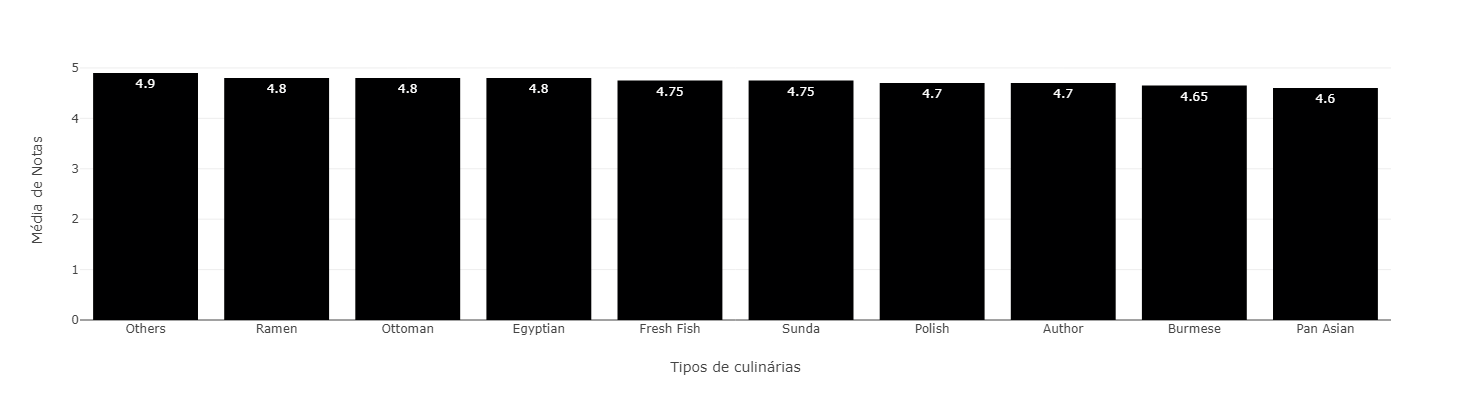

In [60]:
n=10

df_aux = df6[ ['cuisines', 'aggregate_rating'] ].groupby( 'cuisines' ).mean().sort_values( 'aggregate_rating', ascending=False).reset_index()
df_aux['aggregate_rating'] = round( df_aux['aggregate_rating'], 2)
df_aux = df_aux.loc[0:n-1, :]

px.bar( df_aux, x='cuisines', y='aggregate_rating',  text_auto=True, height=400, labels={ 'aggregate_rating': 'Média de Notas', 'cuisines':'Tipos de culinárias' })

### 6.2.2 Top "N" Piores Tipos de Culinárias

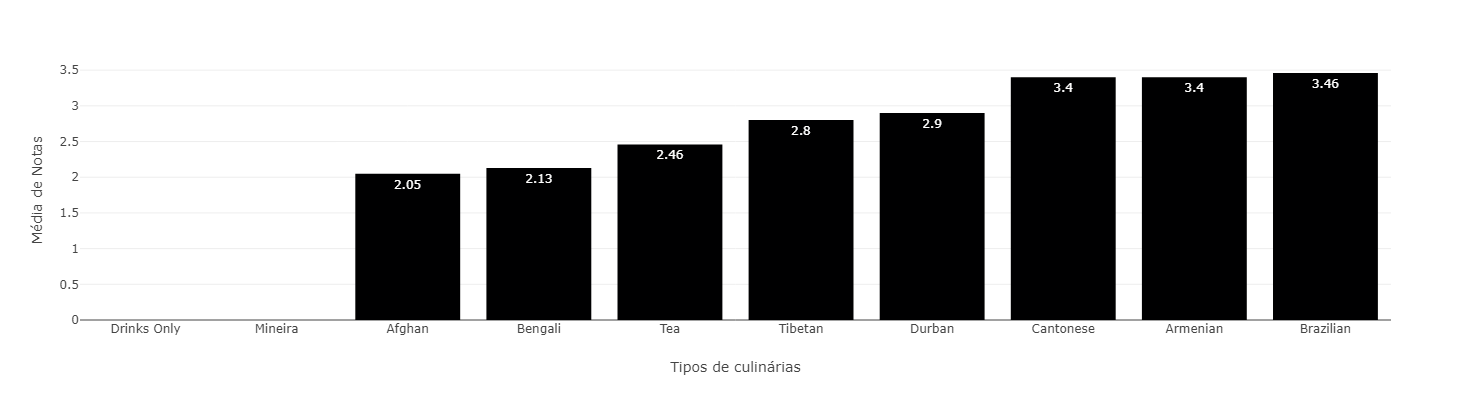

In [61]:
n=10

df_aux = df6[ ['cuisines', 'aggregate_rating'] ].groupby( 'cuisines' ).mean().sort_values( 'aggregate_rating', ascending=True).reset_index()
df_aux['aggregate_rating'] = round( df_aux['aggregate_rating'], 2)
df_aux = df_aux.loc[0:n-1, :]

px.bar( df_aux, x='cuisines', y='aggregate_rating',  text_auto=True, height=400, labels={ 'aggregate_rating': 'Média de Notas', 'cuisines':'Tipos de culinárias' })